<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355569 entries, 0 to 355568
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   구분번호                355569 non-null  int64  
 1   발생년월                355569 non-null  object 
 2   주야                  355569 non-null  object 
 3   시군구                 355569 non-null  object 
 4   사고내용                355569 non-null  object 
 5   사망자수                355569 non-null  int64  
 6   중상자수                355569 non-null  int64  
 7   경상자수                355569 non-null  int64  
 8   부상신고자수              355569 non-null  int64  
 9   사고유형                355569 non-null  object 
 10  법규위반                355569 non-null  object 
 11  노면상태                355569 non-null  object 
 12  기상상태                355569 non-null  object 
 13  도로형태                355569 non-null  object 
 14  가해운전자 차종            355569 non-null  object 
 15  가해운전자 성별            355569 non-nul

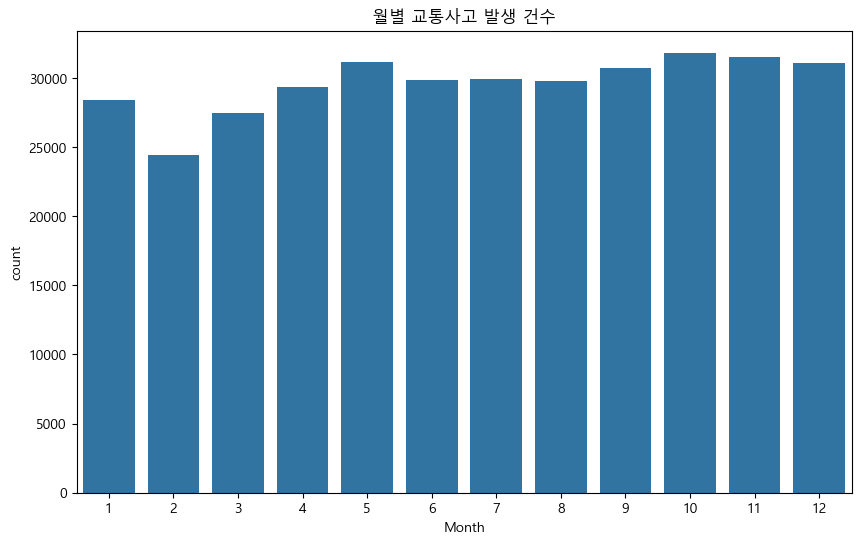

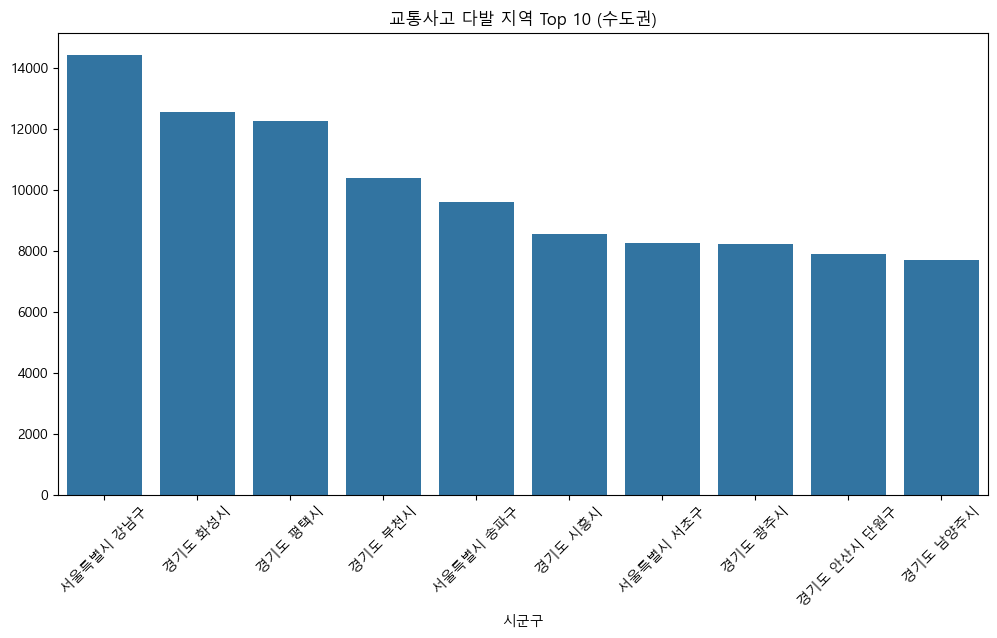

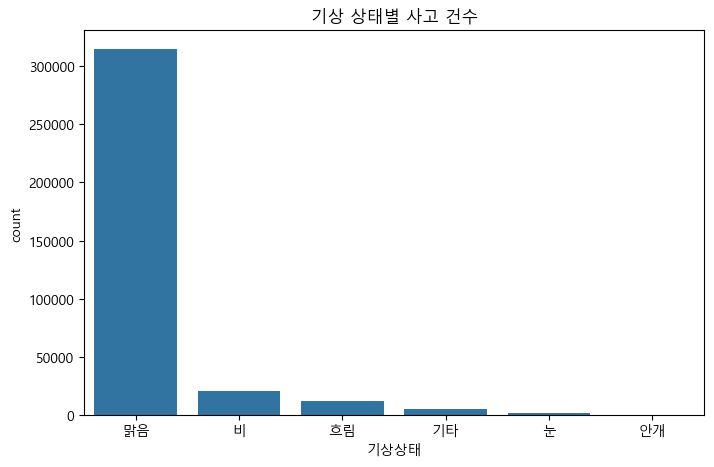

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 예시)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1. 전처리 완료된 데이터 로드
df = pd.read_csv('data/수도권_교통사고_전처리_최종.csv')

# 2. 데이터 기본 정보 확인
print(df.info())
print(df.describe())

# 3. 월별 사고 발생 건수 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', data=df)
plt.title('월별 교통사고 발생 건수')
plt.show()

# 4. 시군구별 사고 발생 상위 10곳
top_10_regions = df['시군구'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_regions.index, y=top_10_regions.values)
plt.title('교통사고 다발 지역 Top 10 (수도권)')
plt.xticks(rotation=45)
plt.show()

# 5. 기상 상태(날씨)별 사고 건수
plt.figure(figsize=(8, 5))
sns.countplot(x='기상상태', data=df, order=df['기상상태'].value_counts().index)
plt.title('기상 상태별 사고 건수')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========================================================
# 1. 환경 설정 (한글 폰트)
# ========================================================
# Windows 사용 시 'Malgun Gothic', Mac 사용 시 'AppleGothic'
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumBarunGothic') # Linux/Colab

plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

# ========================================================
# 2. 데이터 로드
# ========================================================
file_path = 'data/수도권_교통사고_전처리_최종.csv'
df = pd.read_csv(file_path)

print(f"데이터 크기: {df.shape}")
print(df.head())

# ========================================================
# 3. 데이터 기초 통계 및 결측치 확인
# ========================================================
print("\n--- 결측치 비율 확인 ---")
print(df.isnull().mean() * 100)

print("\n--- 수치형 변수 통계 ---")
print(df[['Temperature', 'Precipitation', 'WindSpeed', 'Population_Feature']].describe())

# ========================================================
# 4. 시각화 1: 시계열 분석 (언제 사고가 많이 나는가?)
# ========================================================
plt.figure(figsize=(15, 5))

# 4-1. 월별 사고 건수
plt.subplot(1, 2, 1)
sns.countplot(x='Month', data=df, palette='viridis')
plt.title('월별 교통사고 발생 건수')

# 4-2. 주야별 사고 건수
plt.subplot(1, 2, 2)
sns.countplot(x='주야', data=df, palette='coolwarm')
plt.title('주간 vs 야간 사고 발생 건수')

plt.tight_layout()
plt.show()

# ========================================================
# 5. 시각화 2: 공간 분석 (비율 기반 - 인구 대비 사고율)
# ========================================================
# 단순 건수 Top 15
top_regions = df['시군구'].value_counts().head(15)

# [수정] 인구 대비 사고율 계산 (사고 건수 / 인구수 * 10000)
# 지역별 사고 건수 집계
region_stats = df.groupby('시군구').agg({
    '구분번호': 'count', 
    'Population_Feature': 'mean' # 해당 지역 인구 평균
}).rename(columns={'구분번호': 'Accident_Count'})

# 인구 1만 명당 사고 건수 계산
region_stats['Accident_Rate_Per_10k'] = (region_stats['Accident_Count'] / region_stats['Population_Feature']) * 10000
region_stats = region_stats.sort_values(by='Accident_Rate_Per_10k', ascending=False).head(15)

plt.figure(figsize=(12, 6))
# 왼쪽: 단순 건수
plt.subplot(1, 2, 1)
sns.barplot(x=top_regions.values, y=top_regions.index, palette='Reds_r')
plt.title('단순 사고 건수 Top 15')
plt.xlabel('사고 건수')

# 오른쪽: 인구 대비 사고율
plt.subplot(1, 2, 2)
sns.barplot(x=region_stats['Accident_Rate_Per_10k'], y=region_stats.index, palette='Oranges_r')
plt.title('인구 1만 명당 사고율 Top 15')
plt.xlabel('사고율 (건/1만명)')

plt.tight_layout()
plt.show()

# ========================================================
# 6. 시각화 3: 기상/환경 분석 (비율 기반 - 날씨별 위험도)
# ========================================================
# 강수량 유무 생성
df['Is_Rain'] = df['Precipitation'] > 0
df['Is_Rain_Label'] = df['Is_Rain'].apply(lambda x: '비/눈 옴' if x else '맑음/흐림')

# [수정] 날씨별 '치명적 사고(사망+중상)' 비율 분석
# 전체 사고 중 사망/중상 사고가 차지하는 비중을 날씨별로 비교
df['Is_Fatal'] = (df['사망자수'] + df['중상자수']) > 0

# 날씨별 전체 사고 건수 및 치명적 사고 건수 집계
weather_risk = df.groupby('Is_Rain_Label')['Is_Fatal'].value_counts(normalize=True).unstack() * 100
weather_risk = weather_risk.rename(columns={True: '치명적 사고 비율(%)', False: '일반 사고 비율(%)'})

plt.figure(figsize=(10, 5))
weather_risk['치명적 사고 비율(%)'].plot(kind='bar', color=['skyblue', 'salmon'], rot=0)
plt.title('날씨(강수 유무)에 따른 치명적 사고 발생 비율')
plt.ylabel('비율 (%)')
plt.show()

print("\n--- 날씨별 사고 심각도 비율 ---")
print(weather_risk)

# 기온 분포 확인
plt.figure(figsize=(10, 5))
sns.histplot(df['Temperature'], bins=30, kde=True, color='orange')
plt.title('사고 발생 시 기온 분포')
plt.show()

# ========================================================
# 7. 시각화 4: 상관관계 분석 (변수 간 관계)
# ========================================================
# 상관관계를 볼 수 있는 수치형 컬럼만 선택
corr_cols = ['사망자수', '중상자수', '경상자수', 'Population_Feature', 'Temperature', 'Precipitation', 'WindSpeed']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('주요 변수 간 상관관계 히트맵')
plt.show()